<h1>Monitoring/Learning Curve</h1>

<p>
Analyse de la performance du modèle : Les courbes d'apprentissage sont analysées pour comprendre comment la performance du modèle varie avec la quantité de données d'entraînement. On recherche des signes de surajustement (où la performance sur l'ensemble d'entraînement est bonne mais pauvre sur l'ensemble de validation) ou de sous-ajustement (où la performance est médiocre tant sur l'ensemble d'entraînement que sur l'ensemble de validation).

Choix de la métrique appropriée pour la courbe d'apprentissage qui correspond aux objectifs du modèle. Pour les tâches de régression, des métriques comme le mse(fonction cout) ou RMSE, le R² sont courantes. Pour la classification, des métriques comme le log loss(fonction cout), l'accuracy, la précision, le rappel, ou l'AUC-ROC pourraient être utilisées.


Validation croisée : La validation croisée est utilisée pour obtenir une estimation plus robuste des performances. Chaque point sur la courbe d'apprentissage est la moyenne des scores de plusieurs ensembles de validation croisée, ce qui aide à s'assurer que les résultats ne sont pas dus à une variation aléatoire dans les données.<br>
Dans la validation croisée k-fold, le dataset est divisé en k sous-ensembles (ou "folds") de taille égale. À chaque itération, un sous-ensemble différent est utilisé comme ensemble de validation, et les k-1 restants sont utilisés pour l'entraînement. Dans ce cas, 1/k de l'ensemble de données est utilisé pour la validation à chaque itération. Par exemple, dans une validation croisée 10-fold, 10% des données sont utilisées pour la validation à chaque itération. </p>

<img style="width: 40%;" src="ressources/learning__curve.png" alt="Description de l'image" />

<div style="background-color: white;"><h1 style="color: #000; font-family: bold; text-align: center">Interprétation des courbes d'apprentissage</h1>

<img style="width: 60%;" src="ressources/modele_.png" alt="Description de l'image" />
<img style="width: 60%;" src="ressources/learning_curve.png" alt="Description de l'image" />
<p style="color: #000;"><strong>Underfitting</strong><br>
La courbe de cout(erreur) reste élevé même lorsque le nb d'échantillons augmente.<br>
Le modèle s'adapte mal aux données train et généralise mal aux données de validation</p>
<p style="color: green;">Biais élevé<br>
Le modèle est trop simple et n'a pas la capacité de capturer les relations importantes dans les données.</p>
<p style="color: #000;"><strong>Overfitting</strong><br>
Bon sur le train mais l'erreur de validation reste élevé. Généralise mal.<br> Il y a un grand écart(gap) entre le train score et le score de validation.</p>
<p style="color: green;">Variance élevé<br>
Il a appris le bruit spécifique aux données d'entrainement au lieu de la relation sous-jacente,<br>
ce qui entraine une performance médiocre sur les données de validation</p>
<p style="color: #000;"><strong>Good fitting</strong><br>
Erreur d'entrainement et de validation sont faibles et proches l'une de l'autre.<br>
Le modèle s'adapte bien aux données d'entrainement et généralise bien aux données de validation</p>
<p style="color: green;">Un bon biais et une bonne variance<br>
Le modèle s'adapte bien aux données d'entrainement et généralise bien aux données de validation</p></div>


Résoudre l’underfitting : 
On peut tenter de complexifier le modèle, diminuer la régularisation, d'ajouter plus de features pertinentes ou d’ augmenter la qualité des données


Résoudre l’overfitting : 
On peut tenter de simplifier le modèle, d'ajouter de la régularisation, ou augmenter la quantité de données, car cela permet au modèle d'apprendre de manière plus généralisable en ayant accès à plus d'exemples variés

<img style="width: 60%;" src="ressources/D8tdw.png" alt="Description de l'image" />
<img style="width: 40%;" src="ressources/bias_variance.png" alt="Description de l'image" />

<h1>Comment coder une courbe d'apprentissage(learning curve)</h1>
Lien vers la doc -> <a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html'>Learning_curve documentation</a><br><br>

Exemple code (voir deuxieme notebook après la modélisation) :


In [16]:
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from feature_engine.discretisation import ArbitraryDiscretiser
import math
import pandas as pd
import numpy as np


#import du df
df = pd.read_csv('ressources/dataset2.csv')

print(df.head(), df.shape)
# separation des features et de la variable cible
X = df.drop('charges', axis=1)
y = df[['charges']]
print(f'''verif des dimensions X et Y
      X (dataset sans la variable cible): {X.shape}
      Y (la variable cible) : {y.shape}''')


# division du dataset en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])
print(f''' verif du split 80 20 
80% du dataset : X train -> {X_train.shape}, Y train -> {y_train.shape}
# 20% du dataset : X test -> {X_test.shape}, Y test -> {y_test.shape}''')

# function custom
def log_transform(x):
    return np.log(x + 1)

def custom_bmi_discretizer(df):
    custom_bins = [0, 30, 100, float('inf')]
    bmi_discretizer = ArbitraryDiscretiser(binning_dict={'bmi': custom_bins}, return_object=True)
    df[['bmi']] = bmi_discretizer.fit_transform(df[['bmi']])
    return df

log_transformer = FunctionTransformer(log_transform)
bmi_discretizer_transformer = FunctionTransformer(custom_bmi_discretizer)

#### ======= preprocessing
#processeur pour split le bmi 
preprocessor_bmi = Pipeline(steps=[
    ('bmi_discretize', bmi_discretizer_transformer)
])

#processeur pour les colonnes numériques 
preprocessor_num = Pipeline(steps=[
    ('log', FunctionTransformer(log_transform)),
])
#processeur pour les colonnes catégorielles 
preprocessor_cat = Pipeline(steps=[
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('bmi', preprocessor_bmi, ['bmi']),
        ('num', preprocessor_num, ['age', 'bmi', 'children']),
        ('cat', preprocessor_cat, ['region', 'sex', 'smoker'])
    ]
)

#creation pipeline lasso
pipeline_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regression', Lasso())
])

#test de différents hyperparam d'alpha pour le lasso
param_grid_lasso = {
    'regression__alpha': np.arange(5,10,0.1),
    'regression__precompute': [True],
    'regression__max_iter': [5000],
    
}

### grid search
grid_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=5)

# eviter data leakage -> entraîner le pipeline sur les données d'entraînement 
grid_lasso.fit(X_train, y_train)
best_model = grid_lasso.best_estimator_
#puis predire y sur l'ensemble de test avec le meme pipeline
y_pred = best_model.predict(X_test)
# print(y_pred)

#test des les differents metriques sur modele lasso
#comparaison du y prédit avec le y de test
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error du modèle lasso: {mse}')

r2 = r2_score(y_test, y_pred)

print(f'Coefficient de determination R² du modèle lasso: {r2}')

rmse = math.sqrt(mse)
print(f'Root Mean Squared Error (RMSE) du modèle lasso: {rmse} \n rappel moyenne charge : 13279')

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520 (1337, 7)
verif des dimensions X et Y
      X (dataset sans la variable cible): (1337, 6)
      Y (la variable cible) : (1337, 1)
 verif du split 80 20 
80% du dataset : X train -> (1136, 6), Y train -> (1136, 1)
# 20% du dataset : X test -> (201, 6), Y test -> (201, 1)


c:\Users\socci\Desktop\ML_avance\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14418890.433174133, tolerance: 13974848.585028803
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\socci\Desktop\ML_avance\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13374863.96661377, tolerance: 12712696.685221957
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\socci\Desktop\ML_avance\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14410910.187610626, tolerance: 13974848.585028803
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\socci\Desktop\ML_avance\venv\lib\site-pac

Mean Squared Error du modèle lasso: 10745231.228894157
Coefficient de determination R² du modèle lasso: 0.9258518942009731
Root Mean Squared Error (RMSE) du modèle lasso: 3277.9919507061268 
 rappel moyenne charge : 13279


c:\Users\socci\Desktop\ML_avance\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2378499.558596015, tolerance: 1290442.0251568267
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\socci\Desktop\ML_avance\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36905189.02576923, tolerance: 2909821.405952846
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\socci\Desktop\ML_avance\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14946717.206939697, tolerance: 4132997.6564295692
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\socci\Desktop\ML_avance\venv\lib\site-packa

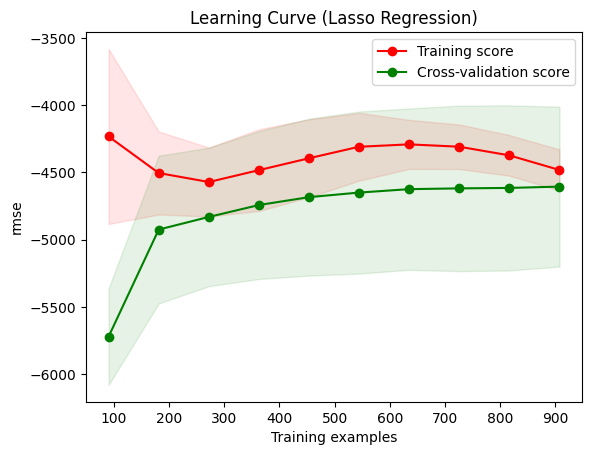

In [23]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, validation_scores = learning_curve(
    estimator = best_model,
    X = X_train,
    y = y_train,
    train_sizes = np.linspace(0.1, 1.0, 10),
    cv = 5,
    scoring = 'neg_root_mean_squared_error'
)

#recuperation des moyennes et des écarts types(facultatif) à chaque cv
train_scores_mean = train_scores.mean(axis = 1)
train_scores_std = train_scores.std(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
validation_scores_std = validation_scores.std(axis = 1)


plt.figure()
plt.title("Learning Curve (Lasso Regression)")
plt.xlabel("Training examples")
plt.ylabel("rmse")


# afficher les points
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

# relier les points
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")


plt.legend()
plt.show()